https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

Датасет по невыплате кредитов

Задача: 
1. EDA, 
2. построение моделей, 
3. **анализ и визуализация влияния признаков на целевую переменную** в целом и по отдельным клиентам при помощи библиотеки SHAP (SHapley Additive exPlanations).

In [155]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [156]:
import pandas as pd #импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve,  accuracy_score, make_scorer, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

### I. Изучаем датасет по невыплате по кредитам

In [157]:
df_credit = pd.read_excel('/Users/Alisa/Downloads/default of credit card clients.xls', index_col = 'Unnamed: 0')

In [158]:
df_credit.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


#### Описание датасета 
(отсюда https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
1. X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. #Размер кредита
2. X2: Gender (1 = male; 2 = female). #Гендер
3. X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). #Уровень образования
4. X4: Marital status (1 = married; 2 = single; 3 = others). #Семейный статус
5. X5: Age (year). #Возраст
6. X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. #Информация об оплате платежей за последние 6 месяцев: закодированы начилие и величина просрочки
7. X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. #Величина счета к оплате, в течение последних 6 месяцев, помесячно
8. X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. #Размер платежей, внесенных за последние 6 месяцев, помесячно

In [159]:
df_credit.shape

(30001, 24)

In [160]:
bank_data = df_credit.rename(columns=df_credit.iloc[0]).drop(df_credit.index[0]) #уберем лишнюю строку в шапке

In [161]:
bank_data.info() # общая информация, проверка на пропуски

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   30000 non-null  object
 1   SEX                         30000 non-null  object
 2   EDUCATION                   30000 non-null  object
 3   MARRIAGE                    30000 non-null  object
 4   AGE                         30000 non-null  object
 5   PAY_0                       30000 non-null  object
 6   PAY_2                       30000 non-null  object
 7   PAY_3                       30000 non-null  object
 8   PAY_4                       30000 non-null  object
 9   PAY_5                       30000 non-null  object
 10  PAY_6                       30000 non-null  object
 11  BILL_AMT1                   30000 non-null  object
 12  BILL_AMT2                   30000 non-null  object
 13  BILL_AMT3                   30000 non-null  object


In [162]:
bank_data.duplicated().sum() # проверим на дубли

35

In [163]:
bank_data = bank_data.drop_duplicates() #удаляем повторяющиеся строки

In [164]:
bank_data = bank_data.apply(pd.to_numeric) #приведем данные к числовому типу 

In [165]:
bank_data.describe(include='all') #основные статистические характеристики

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.221258
std,129760.135222,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [166]:
bank_data['default payment next month'].value_counts(normalize=True) #проверим соотношение классов

0    0.778742
1    0.221258
Name: default payment next month, dtype: float64

Имеется дисбаланс классов, учтем это при обучении моделей

### II. Исследовательский анализ данных

interval columns not set, guessing: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


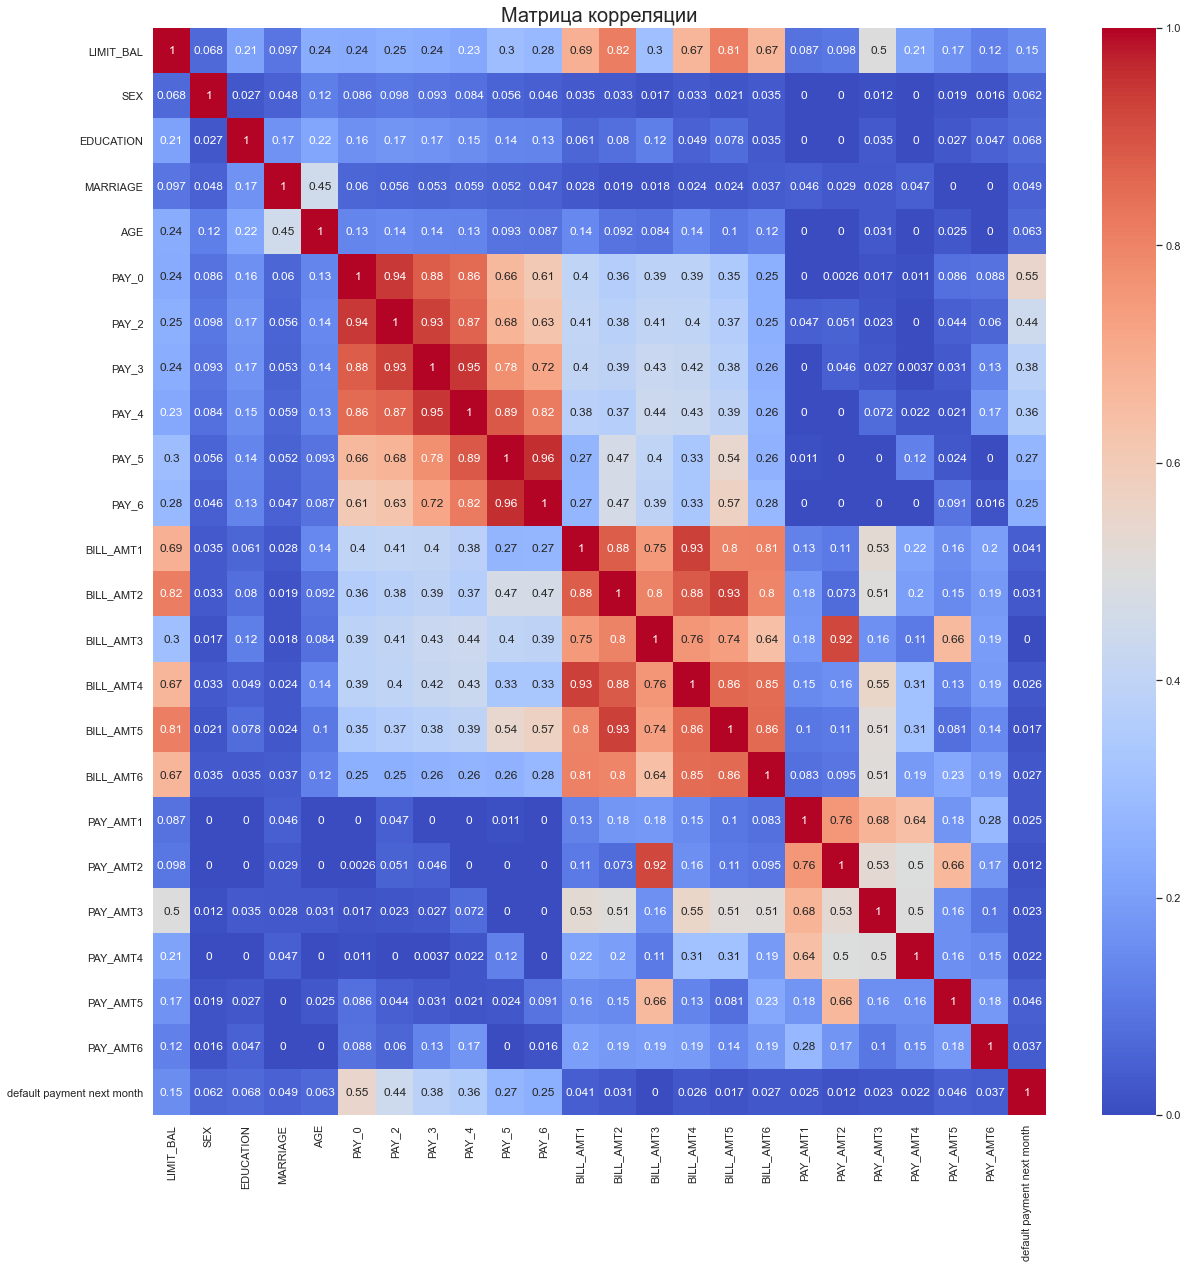

In [167]:
phik = bank_data.phik_matrix()
sns.set(rc={'figure.figsize':(20, 20)})
plt.title('Матрица корреляции', size=20)
sns.heatmap(phik, annot=True, cmap='coolwarm');

Матрица корреляции показывает признаки, имеющие высокую корреляцию между собой: PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6. Они описывают величину просрочи платежей клиентом в каждый из месяцев с апреля по сентябрь. То есть поведение клиента - большая просрочка или аккуратное внесение платежей - остается похожим на протяжении нескольких месяцев наблюдения. Есть сильна корреляция между признаками группы BILL_AMT и PAY_AMT: выставленные счета и внесенные суммы. Также есть корреляция между кредитным лимитом LIMIT_BAL и величиной выставляемых к оплате ежемесячных счетов BILL_AMT. 
В наборе данных имеет место мультиколлинеарность. 

Исследуем различие допускающих невыплаты и аккуратных клиентов по некоторым признакам

#### Возраст

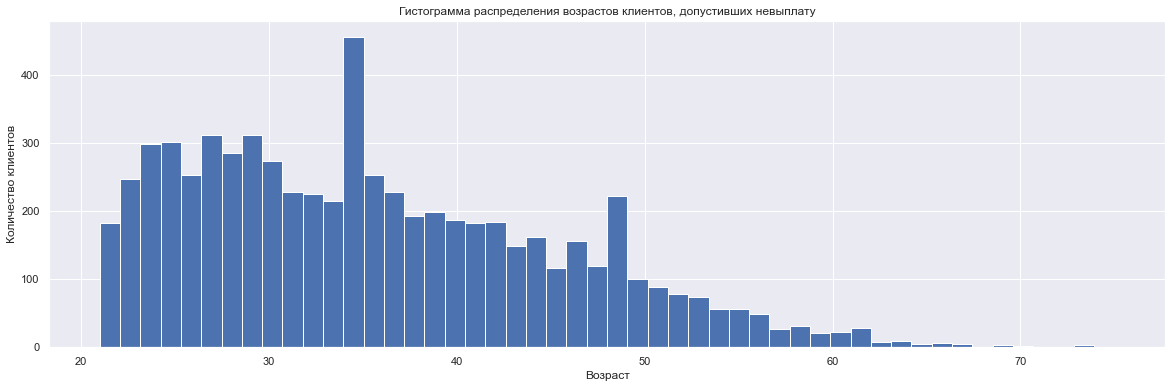

In [168]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения возрастов клиентов, допустивших невыплату')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
bank_data.loc[bank_data['default payment next month'] == 1]['AGE'].hist(bins=50)
plt.show();

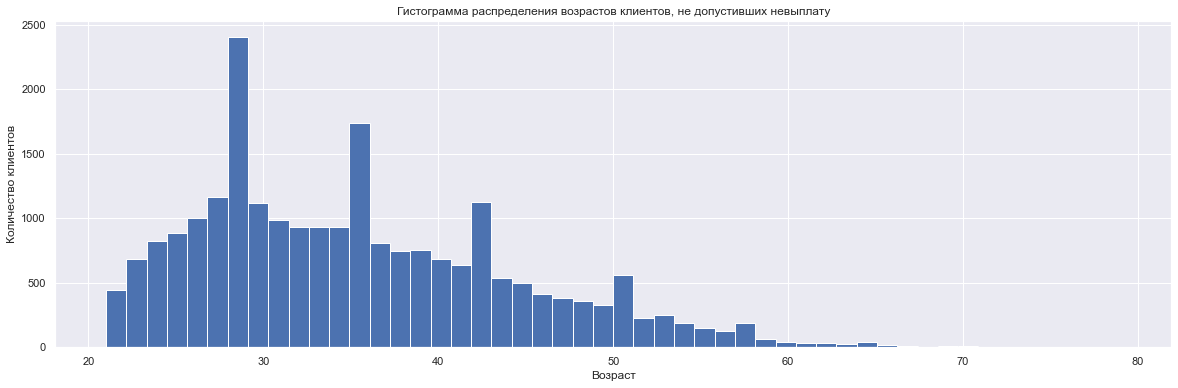

In [169]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения возрастов клиентов, не допустивших невыплату')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
bank_data.loc[bank_data['default payment next month'] == 0]['AGE'].hist(bins=50)
plt.show();

В распределении клиентов по возрасту наблюдаются выбросы, вероятно, ошибки при сборе данных. В целом, не считая ситуации с выбросами, распределение по возрасту похоже у должников и аккуратных клиентов. 

#### Кредитный лимит

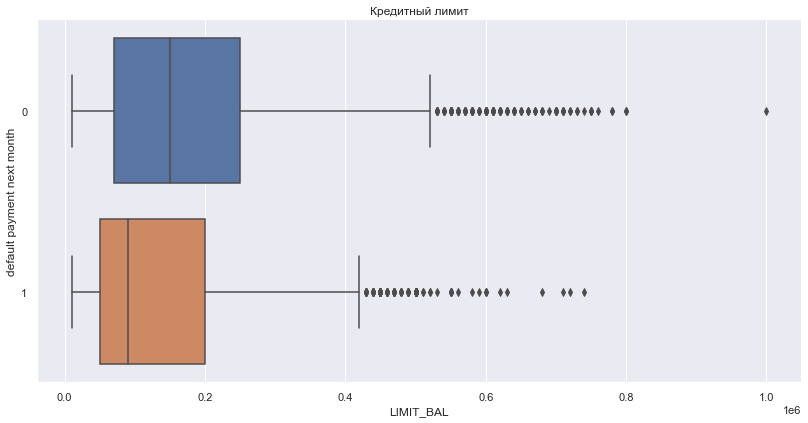

In [170]:
total = sns.catplot(data= bank_data, y='default payment next month', x='LIMIT_BAL', kind="box", orient='h')
total.fig.set_figwidth(12)
total.fig.set_figheight(6)
plt.title('Кредитный лимит')
plt.show();

Медианная величина кредитного лимита у должников несколько меньше

#### Величина счета, выставленного к оплате 

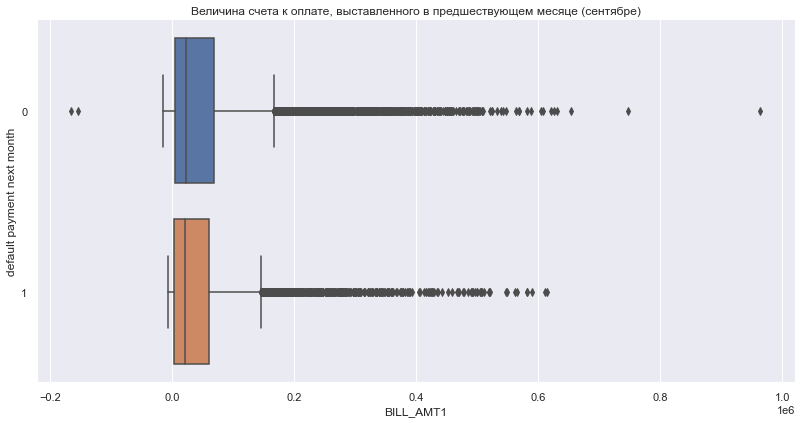

In [171]:
total = sns.catplot(data= bank_data, y='default payment next month', x='BILL_AMT1', kind="box", orient='h')
total.fig.set_figwidth(12)
total.fig.set_figheight(6)
plt.title('Величина счета к оплате, выставленного в предшествующем месяце (сентябре)')
plt.show();

По величине счета, выставленного к оплате в предшествующем месяце, должники и аккуратные плательщики не отличаются

#### Образование, гендер, семеный статус

In [172]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

Создадим **датасет со сбалансированным количеством экземпляров классов** для исследования названных выше параметров. При этом мы не учтем часть данных. 

In [173]:
bank_data['default payment next month'].value_counts() #дисбаланс классов

0    23335
1     6630
Name: default payment next month, dtype: int64

In [174]:
random_state = 1
df_0 = bank_data.loc[bank_data['default payment next month'] == 0]
df_0 = df_0.sample(6630)
df_1 = bank_data.loc[bank_data['default payment next month'] == 1]
frames = [df_0, df_1]
bank_data = pd.concat(frames)
bank_data = bank_data.sample(frac = 1)

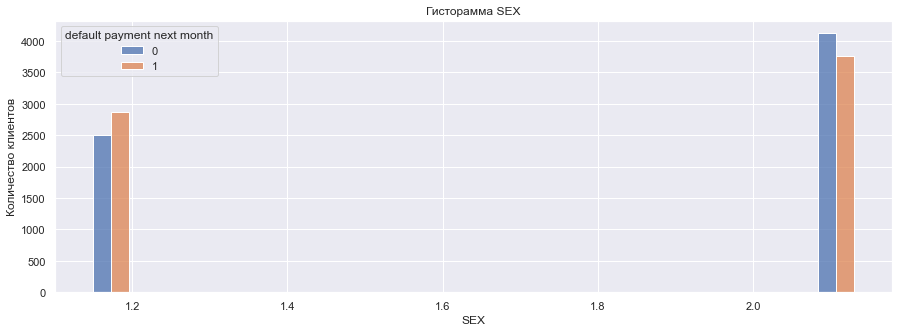

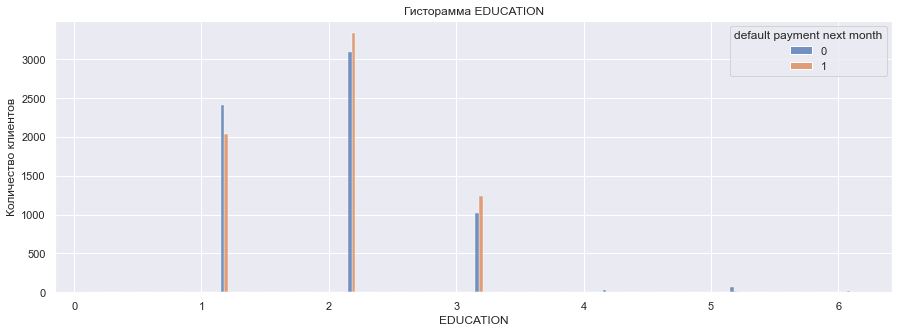

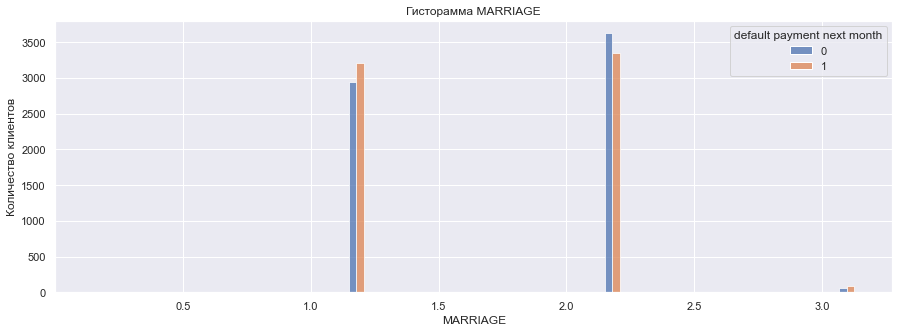

In [175]:
for i in categorical_features:
    plt.figure(figsize=(15,5))
    plt.ylabel('Количество клиентов')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    sns.histplot(data=bank_data, x=i, hue='default payment next month', multiple='dodge', shrink=0.7)
    plt.show();

Гистограммы позволяют заметить (на этой небольшой выборке), что мужчины немного больше склонны к невыплате долга, как и люди, закончившие университет, по сравнению с теми, кто закончил только школу.

### III. Обучение моделей

Используем датасет, в котором классы сбалансированы 1:1. Его мы получили выше. Данные при этом были частично отброшены. Проблему дисбаланса классов можно решить разными способами. Этот способ выбираем для быстроты расчетов: меньший датасет потребует меньшей мощности вычислений. 

In [176]:
X_train, X_test, y_train, y_test = train_test_split(bank_data.drop(columns='default payment next month'), 
                                                    bank_data['default payment next month'], 
                                                    random_state=1)

**Протестируем модели** для бинарной классификации. Это модели, представляющие собой ансамбли "деревьев", использующие градиентный бустинг. Данные модели не требуют масштабирования данных.

#### XGBoost

In [177]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state = 1)

In [178]:
params = {"max_depth":[3, 6],   #можно настроить большее число параметров
          "min_child_weight":[5, 7],
          "learning_rate":[0.3, 0.1, 0.03],
          "n_estimators":[75, 125]}

xgb_classifier = GridSearchCV(xgb_model, param_grid=params)
xgb_classifier.fit(X_train, y_train)

xgb_classifier.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 75}

In [179]:
predictions =  xgb_classifier.predict(X_test)

In [180]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f_score = (2 * precision * recall) / (precision + recall)       

In [181]:
ix = np.argmax(f_score)
print(f'Best Threshold={thresholds[ix]}, F-Score={f_score[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.667, Precision=0.740, Recall=0.607


#### CatBoost

In [182]:
category = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [183]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state = 1, cat_features = category)

In [185]:
params = {'max_depth': [5, 7, 9], #можно настроить большее число параметров
          'learning_rate':[0.03, 0.1], 
          'n_estimators':[75, 125]}

cat_classifier = GridSearchCV(cat_model, param_grid=params)
cat_classifier.fit(X_train, y_train, verbose=False)

cat_classifier.best_params_

{'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 125}

In [186]:
predictions = cat_classifier.predict(X_test)

In [187]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f_score = (2 * precision * recall) / (precision + recall)   

In [188]:
ix = np.argmax(f_score)
print(f'Best Threshold={thresholds[ix]}, F-Score={f_score[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.664, Precision=0.751, Recall=0.595


Выбор модели зависит от того, какую метрику нужно максимизировать. В данном случае нужно максимально выявить тех клиентов, которые не выплатят долги. Наиболее важной метрикой будет, вероятно, recall, в таком случае подходящей моделью - XGBoost

#### ROC-AUC

In [200]:
probabilities_one_test = xgb_classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities_one_test)
roc_auc

0.7663424497055982

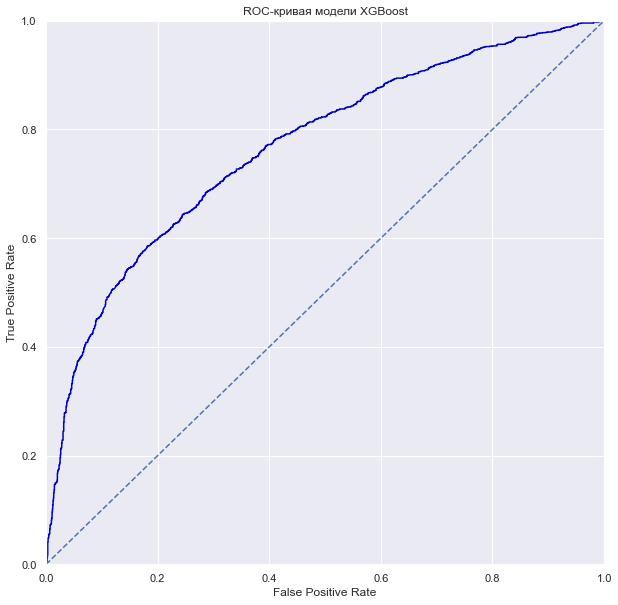

In [207]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure(figsize = (10, 10))
plt.plot(fpr, tpr, color = 'mediumblue')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели XGBoost')
plt.show() 

### IV. Визуализация значения признаков

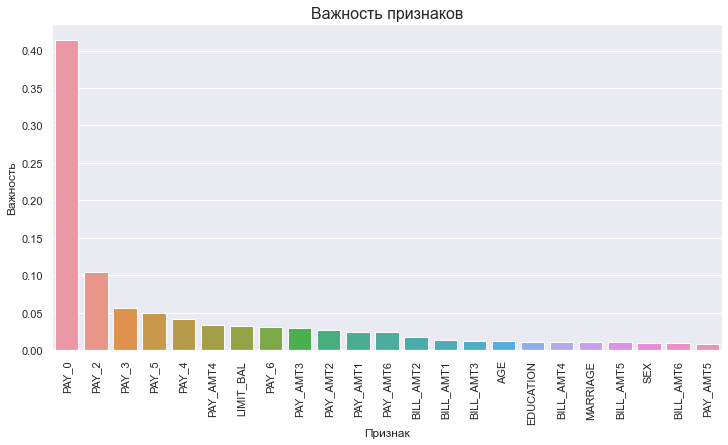

In [208]:
importances = pd.DataFrame(data = {
          'Attribute': X_train.columns,
          'Importance': xgb_classifier.best_estimator_.feature_importances_})
importances = importances.sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (12,6))
sns.barplot(x = importances['Attribute'], y = importances['Importance'])
plt.title('Важность признаков', size=16)
plt.xticks(rotation = 'vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show();

**Визуализация при помощи библиотеки SHAP** (SHapley Additive exPlanations): определение вклада признаков в процесс, определяющий целевую переменную, по формуле Шепли

In [209]:
!pip install shap -q

In [210]:
import shap

shap.initjs()

#### XGBoost

In [211]:
explainer_xgb = shap.Explainer(xgb_classifier.best_estimator_)
shap_values_xgb = explainer_xgb.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


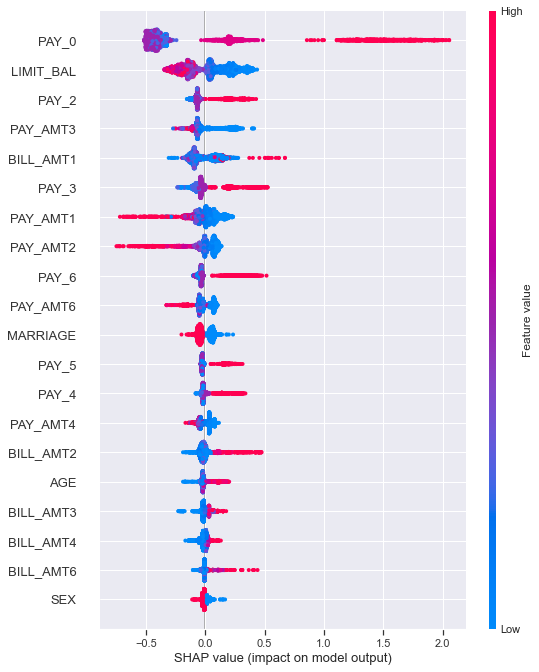

In [212]:
shap.summary_plot(shap_values_xgb, X_test)

#### CatBoost

In [213]:
explainer_cat = shap.Explainer(cat_classifier.best_estimator_)
shap_values_cat = explainer_cat.shap_values(X_test)

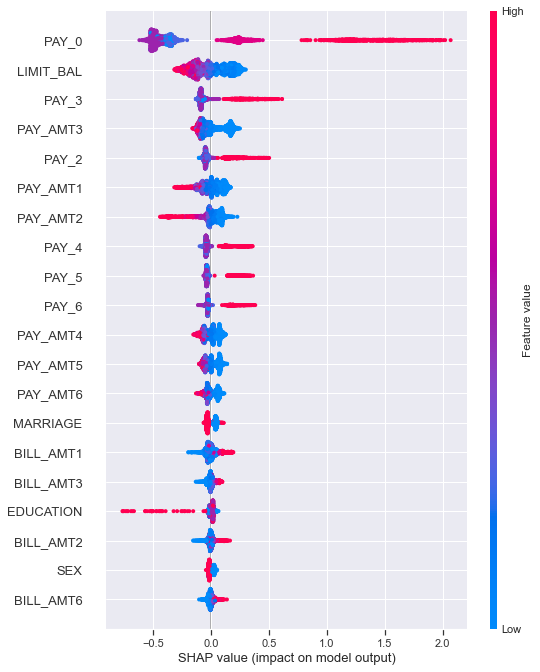

In [214]:
shap.summary_plot(shap_values_cat, X_test)

In [217]:
idx = 3
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[idx,:], X_train.iloc[idx,:])

In [218]:
idx = 3
shap.force_plot(explainer_cat.expected_value, shap_values_cat[idx,:], X_train.iloc[idx,:])

### V. Интерпретация результатов

In [215]:
df_credit.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


**Выделим самые важные факторы, предсказывающие вероятность невыплаты клиентом платежей банку**

**PAY_O**. Это информация по осуществлению платежей клиентом за сентябрь (т.е. по состоянию на сентябрь), самый недавний месяц (в датасете сравнивали данные за 6 месяцев 2005 г.: апрель - сентябрь). Большие значения показывают, что клиент на данный момент задерживает платежи по своему кредиту на несколько месяцев (указывается фактически количество месяцев просрочки). 

Т.е. неплательщики (на данный момент времени), задерживающие выплаты на несколько месяцев, с большей вероятностью не выплатят деньги и в следующий месяц. 

**PAY_2, PAY_3, PAY_4, PAY_5, PAY_6**. Аналогичны PAY_O, но отражает просрочки по выплатам в предшествующих месяцах.

**LIMIT_BAL** Показывает, какой кредит выдан клиенту. Тут выявляется закономерность: чем больше кредит, тем меньше вероятность просрочки. Вероятно, большие кредиты выдавались проверенным аккуратным клиентам.

**PAY_AMT1, PAY_AMT2, PAY_AMT3** - размер выплат, сделанных клиентом в предшествующие месяцы: чем он больше, тем меньше вероятности невыплаты. 